C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 2 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 10 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 20 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
C:\Users\ilyas\AppData\Local\Programs\Python\Python312\Lib\site-packages\numba\cuda\dispatcher.py:536: NumbaPerformanceWarning: Grid size 98 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


   Размер вектора  Время (CPU)  Время (GPU)   Ускорение
0            1000     0.000000     0.533104    0.000000
1            5000     0.001001     0.000991    1.009865
2           10000     0.001505     0.001173    1.282724
3           50000     0.009485     0.001358    6.985426
4          100000     0.017475     0.000997   17.535167
5          500000     0.092032     0.000998   92.192739
6         1000000     0.276944     0.002244  123.428541


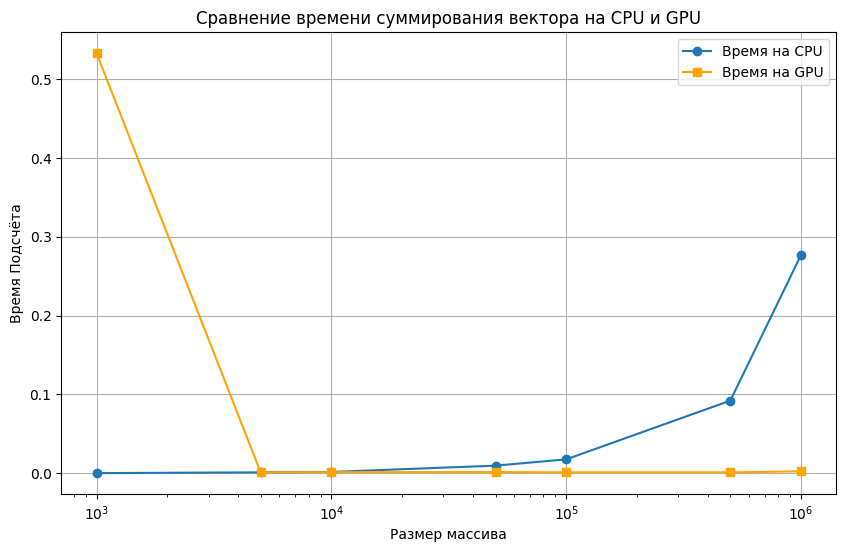

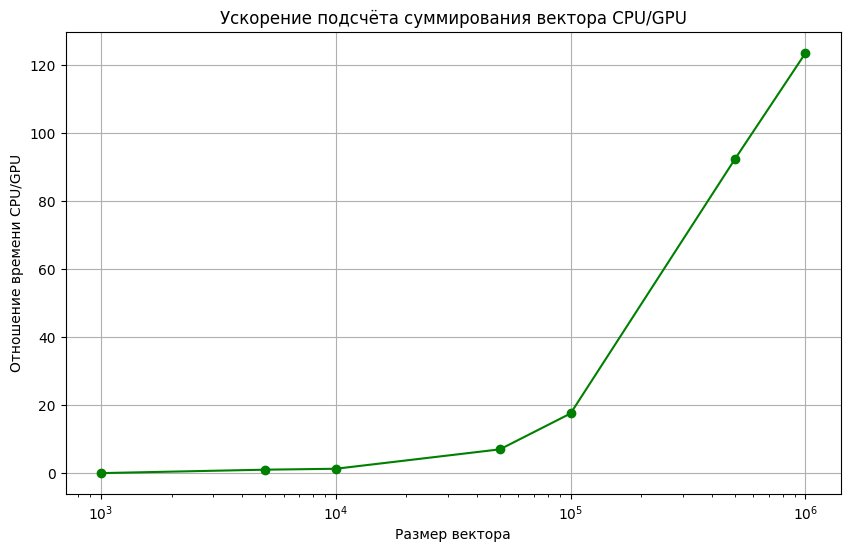

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
import pandas as pd
     
#сумма на CPU
def vecsum_cpu(vec):
    result = 0.0
    for i in range(len(vec)):
        result += vec[i]
    return result

@cuda.jit
def gpu_sum_kernel(vec, result):
    temp = cuda.shared.array(512, dtype=np.float32)
    idx = cuda.grid(1)

    if idx < vec.size:
        temp[cuda.threadIdx.x] = vec[idx]
    else:
        temp[cuda.threadIdx.x] = 0.0

    cuda.syncthreads()

    i = cuda.blockDim.x // 2
    while i > 0:
        if cuda.threadIdx.x < i:
            temp[cuda.threadIdx.x] += temp[cuda.threadIdx.x + i]
        cuda.syncthreads()
        i //= 2

    if cuda.threadIdx.x == 0:
        cuda.atomic.add(result, 0, temp[0])
        
#сумма на GPU
def vecsum_gpu(vec):
    result = np.zeros(1, dtype=np.float32)
    
    cuda_result = cuda.to_device(result)
    cuda_vec = cuda.to_device(vec)

    threads_per_block = 512
    blocks_per_grid = (vec.size + (threads_per_block - 1)) // threads_per_block
    gpu_sum_kernel[blocks_per_grid, threads_per_block](cuda_vec, cuda_result)
    return cuda_result.copy_to_host()[0]



N = [1000, 5000, 10000, 50000, 100000, 500000, 1000000]
results = {"Размер вектора": [], "Время (CPU)": [], "Время (GPU)": [], "Ускорение": []}

for i in N:
    vec = np.random.rand(i).astype(np.float32)

    start_time = time.time()
    cpu_result = vecsum_cpu(vec)
    cpu_time = time.time() - start_time

    start_time = time.time()
    gpu_result = vecsum_gpu(vec)
    gpu_time = time.time() - start_time

    speedup = cpu_time / gpu_time

    results["Размер вектора"].append(i)
    results["Время (CPU)"].append(cpu_time)
    results["Время (GPU)"].append(gpu_time)
    results["Ускорение"].append(speedup)

df_results = pd.DataFrame(results)
print(df_results)


##############
#Время на CPU
plt.figure(figsize=(10, 6))
plt.plot(df_results["Размер вектора"], df_results["Время (CPU)"], 'o-', label='Время на CPU')
plt.plot(df_results["Размер вектора"], df_results["Время (GPU)"], 's-', label='Время на GPU', color='orange')
plt.xscale("log")
plt.xlabel('Размер массива')
plt.ylabel('Время Подсчёта')
plt.title('Сравнение времени суммирования вектора на CPU и GPU')
plt.grid(True)
plt.legend()
plt.show()

#Ускорение
plt.figure(figsize=(10, 6))
plt.plot(df_results["Размер вектора"], df_results["Ускорение"], 'o-', label='Ускорение', color='green')
plt.xscale("log")
plt.xlabel("Размер вектора")
plt.ylabel('Отношение времени CPU/GPU')
plt.title('Ускорение подсчёта суммирования вектора CPU/GPU')
plt.grid(True)


plt.show()